## Lab 3 SOLUTION: Expected Improvement in BoTorch

Based on https://botorch.org/tutorials/compare_mc_analytic_acquisition

In [1]:
import torch

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood

import math
import numpy as np
import matplotlib.pyplot as plt

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# Hartmann is a standard test function that has a 6 dimensional input.
# We will work on maximizing -1 times the value of this function.
from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(negate=True)

# We will work with our simple 1-dimensional example, to support visualization
def objective(x):
    return torch.sin(x * (2 * math.pi))

First, we generate some random data and fit a SingleTaskGP for a 6-dimensional synthetic test function 'Hartmann6'.

In [2]:
np.random.seed(0)
train_x = torch.rand(3, 1)
train_y = objective(train_x)
noises = torch.ones(len(train_y)) * 0.0001

model = SingleTaskGP(train_x, train_y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))

# This optimizes the parameters of the model
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): SingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

/usr/local/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352443756/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


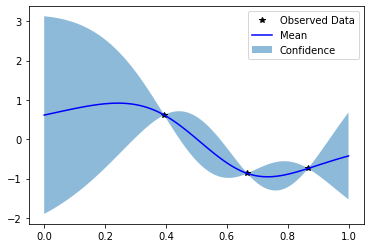

In [3]:
# It's always a good idea to plot the fit.
# Here's a way to plot that pulls out the mean and variance as 
# numpy arrays, if you are more comfortable working with     

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_x = torch.linspace(0, 1, 101, dtype=torch.float, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_x)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])

#### Exercise 1

Write a function that calculates the expected improvement given the posterior mean (m), posterior variance (v),
and the value of the best point observed (best_y), for settings where we are maximizing.
You can use equation (8) on page 7 of the tutorial article, which also appears in the slides.

Your code may need to handle very small variances as a special case to avoid dividing by 0.
The EI for a variance of 0 is max(0,m-best_y).  You may also need to handle small negative variances 
--- treat them as 0.

You can use `scipy.stats.norm.pdf` and `scipy.stats.norm.cdf`

In [ ]:
import scipy.stats

def EI(m,v,best_y):
    ### FILL IN YOUR CODE HERE

#### Exercise 1 solution

In [38]:
import scipy.stats

# The one from Jones Schonlau & Welch 1998
def EI2(m,v,best_y):
    
    if v <= 0:
        return max(0,m-best_y)
    
    delta = m-best_y
    s = np.sqrt(v)
    z = delta / s
    ret = s * scipy.stats.norm.pdf(z)
    ret += delta*scipy.stats.norm.cdf(z)
    return ret

# The version from the tutorial
def EI1(m,v,best_y):
    
    if v <= 0:
        ret = max(0,m-best_y)
    else:   
        delta = m-best_y
        s = np.sqrt(v)
        z = delta / s
        ret = max(0,delta)
        ret += s * scipy.stats.norm.pdf(z) 
        print(z)
        ret -= abs(delta)*scipy.stats.norm.cdf(-1*abs(z))
    
    # This checks whether the two implementations give different values
    difference = ret - EI2(m,v,best_y)
    if abs(difference)>1e-5:
        print('substantial difference: m={} v={} best_y={} diff={})'.format(m, v, best_y, difference))
        
    return ret

EI = EI1

# Test that the two versions give the same values
EI(1,1e-100,0)
EI(2,1,0)
EI(0,2,2)
EI(0,10,2)

1e+50
2.0
-1.414213562373095
-0.6324555320336759


0.5057938380690186

#### Exercise 1 solution

#### End Exercise 1

In [5]:
# It's useful to have the boilerplate for plotting the posterior as its own function
# This takes as input an axis for plotting (ax), a BoTorch model (model), the set of 
# points at which to plot (test_x), and the points that have already been evaluated
# (train_x, train_y)
def plot_posterior(ax,model,test_x,train_x,train_y):
    
    with torch.no_grad():
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x)

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

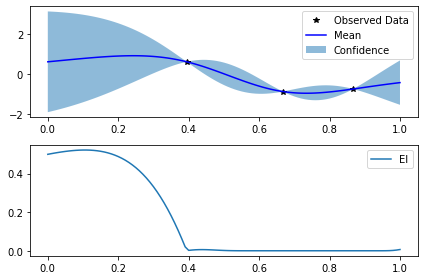

In [6]:
# Using your EI function, we plot the EI below the posterior

f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 4))
test_x = torch.linspace(0, 1, 101, dtype=torch.float, device=device)
acq = np.zeros(101)
best_y = max(train_y.numpy())[0]

# Plot the posterior in the first subplot (ax1)
plot_posterior(ax1,model,test_x,train_x,train_y)
    
# Calculate EI
with torch.no_grad():
    posterior = model.posterior(test_x)
    m = posterior.mvn.mean.numpy()
    v = posterior.mvn.variance.numpy()
    for i in range(len(m)):
        acq[i] = EI(m[i],v[i],best_y)
    
    # Plot EI in the second sub-plot
    ax2.plot(test_x.cpu().numpy(), acq, '-')
    ax2.legend(['EI'])
    
plt.tight_layout()

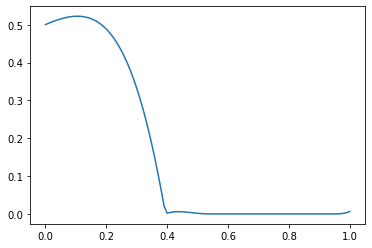

In [7]:
# We can make the same plot using BoTorch
from botorch.acquisition import ExpectedImprovement

best_value = train_y.max()
# This initializes an acquisition function object.
BoTorch_EI = ExpectedImprovement(model=model, best_f=best_value)

# Before running our acquisition function on our test points (test_x),
# we need to convert it from its current form, which is a 1-d tensor containing 101 elements,
# into a 3-d tensor with shape 1 x 1 x 101.
# To do this, we call unsqueeze twice to add the two missing dimensions.
# The argument to unsqueeze tells it at what index to add the extra dimension.
# This is probably best understood with this example:
# >> test_x.shape
# >> torch.Size([101])
# >> test_x.unsqueeze(1).shape
# >> torch.Size([101, 1])
# >> test_x.unsqueeze(1).unsqueeze(0).shape
# >> torch.Size([101, 1, 1])
# This is required because the acquisition function is set up to handle multiple batches 
# of multi-dimensional x values. Adding the two extra dimensions tells the acquisition 
# function that we have 101 batches, each of which contains a single 1-dimensional point.

# The "forward" method of an acquisition function evaluates it on the input points.

acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
plt.plot(test_x.numpy(), acq.detach().numpy())

Now we can use BoTorch to optimize EI.  We use a multiple restarts for our optimization method, using 50 random restarts chosen from 100 initial raw samples.

In [8]:
from botorch.optim import optimize_acqf

new_point, new_point_EI = optimize_acqf(
    acq_function=BoTorch_EI,
    bounds=torch.tensor([[0.0], [1.0]]),
    q=1,
    num_restarts=50,
    raw_samples=100,
    options={},
)

In [9]:
# This is the point that optimized the EI.
new_point_EI

tensor(0.5227)

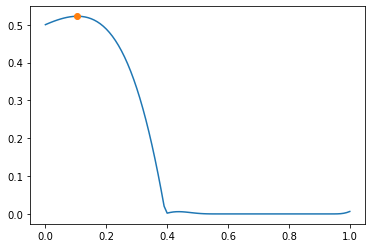

In [10]:
# We can plot it on the EI surface to see that it does indeed optimize EI
acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
plt.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'o')

#### Full BayesOpt loop

The following is a full BayesOpt loop that iteratively: (1) finds the point that optimizes the EI; (2) observes the objective at this point; (3) adds the new data to our training data.  After every evaluation it prints out the new posterior and the EI surface.

Iteration 0, measuring at x=0.14503943920135498


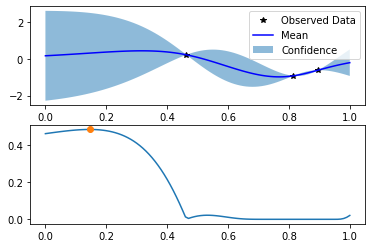

Iteration 1, measuring at x=0.0


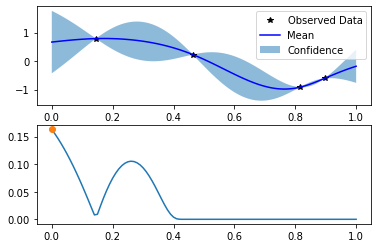

Iteration 2, measuring at x=0.25431206822395325


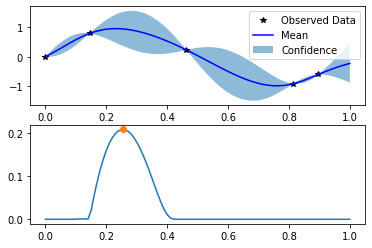

In [12]:
x = torch.rand(3, 1)
y = objective(x)

for i in range(3):
    
    # Fit the model
    noises = torch.ones(len(y)) * 0.0001
    model = SingleTaskGP(x, y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=y.max())
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0.0], [1.0]]),
        q=1,
        num_restarts=50,
        raw_samples=100,
        options={},
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 4))
    test_x = torch.linspace(0, 1, 101, dtype=torch.float, device=device)
    
    # Plot the posterior
    plot_posterior(ax1,model,test_x,x,y)
    
    # Plot EI
    acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'o')
    
    print('Iteration {}, measuring at x={}'.format(i,new_point.item()) )
    plt.show()
    
    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y, objective(new_point)))

#### Exercise 2

Building on the previous cell and Exercise 2 in lab 2, write code that uses Bayesian Optimization to minimize the Hartmann
function over the 6-dimensional unit hypercube with noise-free evaluations.  (I.e., it maximizes negative 1 times the Hartmann function.)

Start with 20 points choosing at random.  Then run 20 iterations of
Bayesian optimization, fitting a Gaussian process with a Matern kernel with nu=0.5.

At the start of the first iteration print out the value of the best point found so far.

After every new iteration print out
- the point being evaluated
- the value of that point
- the value of the best point found so far

Don't forget to adjust the bounds on where we optimize over with optimize_acqf.  This line should be

`bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),`


To help you, here is a partially written loop
   

In [ ]:
from botorch.test_functions import Hartmann
objective = Hartmann(negate=True)
np.random.seed(1)
x = torch.rand(20, 6, device=device, dtype=torch.float)
y = objective(x).unsqueeze(-1)  # add output dimension

print('Value of best point found: {}'.format(y.max()))

best = [y.max()] # This will store the best value

for i in range(20):
    
    # Fit the model
    # FILL IN YOUR CODE HERE.  
    # Take x and y as your training data and producte a fitted "model" object
    
    # Optimize EI
    # FILL IN YOUR CODE HERE
    # Take your model object and y and produce "new_point" which maximizes EI
    
    # Evaluate the objective
    # FILL IN YOUR CODE HERE --- set new_value equal to the value of the objective at the new point
    
    print()
    print(new_point.numpy())
    print('Iteration {:2d}, value={:0.3f}, best value={:0.3f}'.format(
        i,
        new_value.item(),
        max(new_value,y.max()).item()))
    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    best.append(y.max())

#### Exercise 2 Solution

In [16]:
from botorch.test_functions import Hartmann
objective = Hartmann(negate=True)
np.random.seed(1)
x = torch.rand(20, 6, device=device, dtype=torch.float)
y = objective(x).unsqueeze(-1)  # add output dimension

print('Value of best point found: {}'.format(y.max()))

best = [y.max()] # This will store the best value

for i in range(20):
    
    # Fit the model
    noises = torch.ones(len(y)) * 0.0001
    model = SingleTaskGP(x, y, likelihood = FixedNoiseGaussianLikelihood(noise=noises))
    model.covar_module.base_kernel.nu = .5
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=y.max())
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    
    new_value = objective(new_point)
    
    print()
    print(new_point.numpy())
    print('Iteration {:2d}, value={:0.3f}, best value={:0.3f}'.format(
        i,
        new_value.item(),
        max(new_value,y.max()).item()))
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    best.append(y.max())

Value of best point found: 1.432845950126648

[[0.14996117 0.14582032 0.83588636 0.26937553 0.16850464 0.853934  ]]
Iteration  0, value=1.554, best value=1.554

[[0.15535076 0.15603843 0.81077415 0.27885956 0.16764258 0.84172875]]
Iteration  1, value=1.656, best value=1.656

[[0.16008468 0.16587003 0.7875977  0.28798524 0.1670073  0.83047503]]
Iteration  2, value=1.741, best value=1.741

[[0.1643443  0.17560603 0.76578856 0.29692405 0.16658281 0.82079333]]
Iteration  3, value=1.812, best value=1.812

[[0.16724052 0.18690462 0.74680096 0.3076205  0.16351703 0.81511956]]
Iteration  4, value=1.845, best value=1.845

[[0.17035529 0.18062164 0.7359086  0.30020377 0.16997075 0.8034602 ]]
Iteration  5, value=1.923, best value=1.923

[[0.17166452 0.18166631 0.71915096 0.29738292 0.17067188 0.79028404]]
Iteration  6, value=1.984, best value=1.984

[[0.17720501 0.18687417 0.70086384 0.2992742  0.1762843  0.78514993]]
Iteration  7, value=2.069, best value=2.069

[[0.18107711 0.19150133 0.6825846 

Text(0, 0.5, 'Best value found')

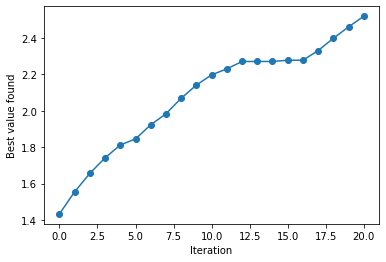

In [17]:
plt.plot(best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')